#### This notebook will discuss the GANs

In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishesh1412/celebrity-face-image-dataset")

print("Path to dataset files:", path)

/home/blackcat/BlackCat/Project_Personal/Generative AI/GANs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 52.9M/52.9M [00:47<00:00, 1.17MB/s]

Extracting files...


Path to dataset files: /home/blackcat/.cache/kagglehub/datasets/vishesh1412/celebrity-face-image-dataset/versions/1


In [7]:
DATA_DIR = path
image_size = 64
batch_size = 256
states = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [8]:
train_ds =ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*states)
]))


train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)

In [9]:
import torch 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline 

In [10]:
def denorm(img_tensors):
    return img_tensors * states[1][0] + states[0][0]

In [14]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), 
                        nrow=8).permute(1,2,0))

def show_batch(d1,nmax=64):
    for images, _ in d1:
        show_images(images, nmax)
        break


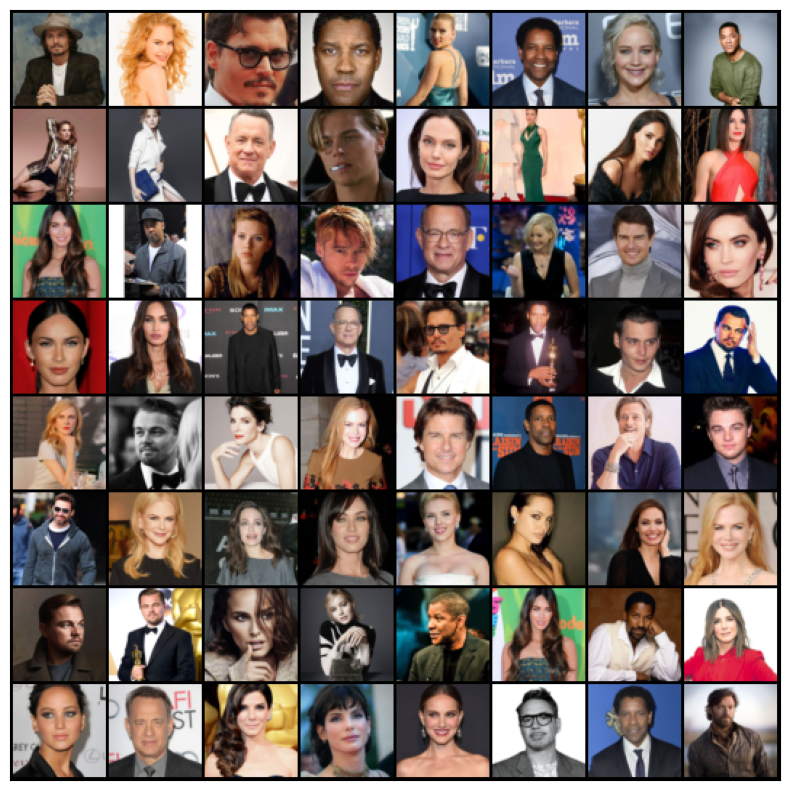

In [15]:
show_batch(train_dl)

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, d1, device):
        self.d1=d1
        self.device = device
    
    def __iter__(self):
        for b in self.d1:
            yield to_device(b, self.device)

        def __len__(self):
            return len(self.d1)

In [17]:
device = get_default_device()
device

device(type='cpu')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)

In [19]:
import torch.nn as nn

In [79]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()


)

In [80]:
discriminator = to_device(discriminator, device)

In [81]:
latent_size = 128

In [83]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()


)

In [84]:
generator = to_device(generator, device)

In [98]:
import torch.nn.functional as F
def train_discriminator(real_images, opt_d):

    opt_d.zero_grad()
    real_preds =discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0),1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    #opt_d.stop()
    return loss.item(), real_score, fake_score

In [100]:
import torch.nn.functional as F
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_image = generator(latent)

    preds = discriminator(fake_image)
    targets = torch.ones(batch_size,1,device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    #opt_g.stop()

    return loss.item()

In [88]:
from torchvision.utils import save_image

In [89]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [90]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated_image_{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [91]:
fixed_latent = torch.rand(64, latent_size, 1,1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999113..0.99991256].


Saving generated_image_0000.png


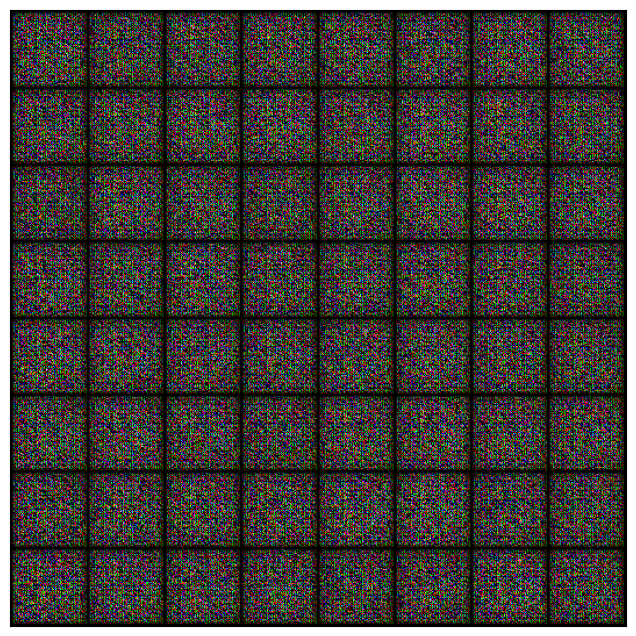

In [92]:
save_samples(0,fixed_latent)

In [93]:
from tqdm import tqdm
import torch.nn.functional as F

In [95]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()


    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))


    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):

            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)



        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score
        ))

        save_samples(epoch+start_idx, fixed_latent, show=False)
    return losses_g, losses_d, real_scores, fake_scores



In [96]:
!pip3 install IProgress
!pip3 install ipywidgets

In [102]:
%%time
lr = 0.005
epochs = 40
history = fit(epochs, lr)

8it [01:07,  8.41s/it]


Epoch [1/40], loss_g: 0.9428, loss_d: 1.4106, real_score: 0.4287, fake_score: 0.4133
Saving generated_image_0001.png


8it [01:04,  8.05s/it]


Epoch [2/40], loss_g: 0.9207, loss_d: 1.4180, real_score: 0.4236, fake_score: 0.4107
Saving generated_image_0002.png


8it [01:04,  8.12s/it]


Epoch [3/40], loss_g: 0.9362, loss_d: 1.4094, real_score: 0.4152, fake_score: 0.4008
Saving generated_image_0003.png


8it [01:06,  8.34s/it]


Epoch [4/40], loss_g: 0.9059, loss_d: 1.3542, real_score: 0.4463, fake_score: 0.4127
Saving generated_image_0004.png


8it [01:05,  8.16s/it]


Epoch [5/40], loss_g: 0.9402, loss_d: 1.4581, real_score: 0.4112, fake_score: 0.4197
Saving generated_image_0005.png


8it [01:09,  8.65s/it]


Epoch [6/40], loss_g: 0.9316, loss_d: 1.4288, real_score: 0.4172, fake_score: 0.4125
Saving generated_image_0006.png


8it [01:06,  8.30s/it]


Epoch [7/40], loss_g: 0.8989, loss_d: 1.3472, real_score: 0.4448, fake_score: 0.4049
Saving generated_image_0007.png


8it [01:03,  7.93s/it]


Epoch [8/40], loss_g: 0.8968, loss_d: 1.3186, real_score: 0.4545, fake_score: 0.4007
Saving generated_image_0008.png


8it [01:04,  8.07s/it]


Epoch [9/40], loss_g: 0.9233, loss_d: 1.4038, real_score: 0.4284, fake_score: 0.4133
Saving generated_image_0009.png


8it [01:04,  8.07s/it]


Epoch [10/40], loss_g: 0.9285, loss_d: 1.3448, real_score: 0.4579, fake_score: 0.4136
Saving generated_image_0010.png


8it [01:05,  8.20s/it]


Epoch [11/40], loss_g: 0.9118, loss_d: 1.4058, real_score: 0.4194, fake_score: 0.4042
Saving generated_image_0011.png


8it [01:06,  8.34s/it]


Epoch [12/40], loss_g: 0.9315, loss_d: 1.4150, real_score: 0.4188, fake_score: 0.4077
Saving generated_image_0012.png


8it [01:05,  8.13s/it]


Epoch [13/40], loss_g: 0.8937, loss_d: 1.4954, real_score: 0.3853, fake_score: 0.4042
Saving generated_image_0013.png


8it [01:06,  8.31s/it]


Epoch [14/40], loss_g: 0.9151, loss_d: 1.3076, real_score: 0.4707, fake_score: 0.4140
Saving generated_image_0014.png


8it [01:05,  8.15s/it]


Epoch [15/40], loss_g: 0.8910, loss_d: 1.2942, real_score: 0.4682, fake_score: 0.4027
Saving generated_image_0015.png


8it [01:07,  8.49s/it]


Epoch [16/40], loss_g: 0.9125, loss_d: 1.4525, real_score: 0.4049, fake_score: 0.4081
Saving generated_image_0016.png


8it [01:04,  8.10s/it]


Epoch [17/40], loss_g: 0.9183, loss_d: 1.4613, real_score: 0.3994, fake_score: 0.4039
Saving generated_image_0017.png


8it [01:06,  8.34s/it]


Epoch [18/40], loss_g: 0.9078, loss_d: 1.4815, real_score: 0.3949, fake_score: 0.4071
Saving generated_image_0018.png


8it [01:06,  8.34s/it]


Epoch [19/40], loss_g: 0.9061, loss_d: 1.3815, real_score: 0.4338, fake_score: 0.4086
Saving generated_image_0019.png


8it [01:07,  8.39s/it]


Epoch [20/40], loss_g: 0.9132, loss_d: 1.3496, real_score: 0.4467, fake_score: 0.4087
Saving generated_image_0020.png


8it [01:04,  8.10s/it]


Epoch [21/40], loss_g: 0.9203, loss_d: 1.4258, real_score: 0.4182, fake_score: 0.4029
Saving generated_image_0021.png


8it [01:04,  8.00s/it]


Epoch [22/40], loss_g: 0.9119, loss_d: 1.4032, real_score: 0.4234, fake_score: 0.4074
Saving generated_image_0022.png


8it [00:59,  7.47s/it]


Epoch [23/40], loss_g: 0.9223, loss_d: 1.4351, real_score: 0.4102, fake_score: 0.4055
Saving generated_image_0023.png


8it [01:04,  8.09s/it]


Epoch [24/40], loss_g: 0.9245, loss_d: 1.4201, real_score: 0.4181, fake_score: 0.4073
Saving generated_image_0024.png


8it [01:07,  8.43s/it]


Epoch [25/40], loss_g: 0.9139, loss_d: 1.3473, real_score: 0.4393, fake_score: 0.3992
Saving generated_image_0025.png


8it [01:04,  8.09s/it]


Epoch [26/40], loss_g: 0.9116, loss_d: 1.3897, real_score: 0.4226, fake_score: 0.3984
Saving generated_image_0026.png


8it [01:04,  8.11s/it]


Epoch [27/40], loss_g: 0.9085, loss_d: 1.4420, real_score: 0.4117, fake_score: 0.4044
Saving generated_image_0027.png


8it [01:03,  8.00s/it]


Epoch [28/40], loss_g: 0.8923, loss_d: 1.3736, real_score: 0.4369, fake_score: 0.4125
Saving generated_image_0028.png


8it [01:08,  8.52s/it]


Epoch [29/40], loss_g: 0.9023, loss_d: 1.3295, real_score: 0.4480, fake_score: 0.4018
Saving generated_image_0029.png


8it [01:08,  8.57s/it]


Epoch [30/40], loss_g: 0.9152, loss_d: 1.4825, real_score: 0.4022, fake_score: 0.4136
Saving generated_image_0030.png


8it [01:04,  8.02s/it]


Epoch [31/40], loss_g: 0.9353, loss_d: 1.5040, real_score: 0.3833, fake_score: 0.4047
Saving generated_image_0031.png


8it [01:03,  7.99s/it]


Epoch [32/40], loss_g: 0.9166, loss_d: 1.2847, real_score: 0.4711, fake_score: 0.4051
Saving generated_image_0032.png


8it [01:03,  7.99s/it]


Epoch [33/40], loss_g: 0.9014, loss_d: 1.3070, real_score: 0.4597, fake_score: 0.4039
Saving generated_image_0033.png


8it [01:03,  7.99s/it]


Epoch [34/40], loss_g: 0.9182, loss_d: 1.3787, real_score: 0.4320, fake_score: 0.4024
Saving generated_image_0034.png


8it [01:04,  8.07s/it]


Epoch [35/40], loss_g: 0.9123, loss_d: 1.3357, real_score: 0.4485, fake_score: 0.4038
Saving generated_image_0035.png


8it [01:04,  8.07s/it]


Epoch [36/40], loss_g: 0.9231, loss_d: 1.3613, real_score: 0.4455, fake_score: 0.4084
Saving generated_image_0036.png


8it [01:04,  8.00s/it]


Epoch [37/40], loss_g: 0.9049, loss_d: 1.5542, real_score: 0.3674, fake_score: 0.4086
Saving generated_image_0037.png


8it [01:04,  8.06s/it]


Epoch [38/40], loss_g: 0.9159, loss_d: 1.4499, real_score: 0.4009, fake_score: 0.4052
Saving generated_image_0038.png


8it [01:12,  9.06s/it]


Epoch [39/40], loss_g: 0.9237, loss_d: 1.2500, real_score: 0.4871, fake_score: 0.4017
Saving generated_image_0039.png


8it [01:02,  7.86s/it]


Epoch [40/40], loss_g: 0.9160, loss_d: 1.2867, real_score: 0.4742, fake_score: 0.4074
Saving generated_image_0040.png
CPU times: user 2h 26min 2s, sys: 14min 8s, total: 2h 40min 10s
Wall time: 43min 48s


In [103]:
losses_g, losses_d, real_scores, fake_scores = history

In [104]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

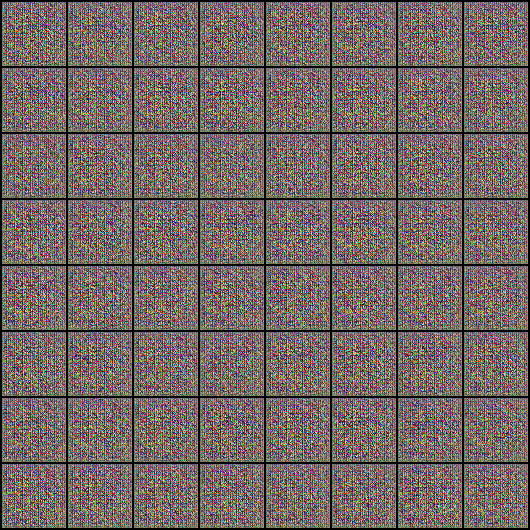

In [105]:
from IPython.display import Image
Image('./generated/generated_image_0001.png')

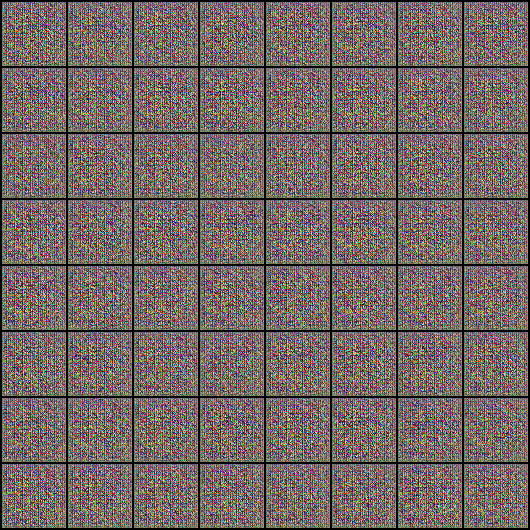

In [109]:
Image('./generated/generated_image_0200.png')